<a href="https://colab.research.google.com/github/kirubanath/AI-DS_learnings/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Lab 2

## Assignment 3 (Deadline : 05/02/2023 11:59PM)

Total Points : 25

Your answers must be entered in LMS by midnight of the day it is due. 

If the question requires a textual response, you can create a PDF and upload that. 

The PDF might be generated from MS-WORD, LATEX, the image of a hand- written response, or using any other mechanism. 

Code must be uploaded and may require demonstration to the TA. 

Numbers in the parentheses indicate points allocated to the question. 

**Naming Convention**: FirstName_LastName_Lab3_TLP23.ipynb

**Assignment**: 3-class Sentiment Analysis with LSTM on Twitter Data
 

**Objective**:
The objective of this assignment is to train a LSTM neural network to perform 3-class sentiment analysis on Twitter data.
 

**Dataset**:
The dataset used in this assignment is the Sentiment140 dataset, which can be downloaded from http://help.sentiment140.com/for-students. The dataset consists of 1.6 million tweets, labeled as positive (4), neutral (2), or negative (0)


*   Collect a sample of at least 100,000 tweets from the dataset **(1 points)**


*   Preprocess the text data by removing punctuation, lowercasing, removing stop words, and tokenizing the words **(3 points)**

*   Split the data into training and testing sets, and pad the sequences to the same length **(2 points)**

*   Build a LSTM model to classify the tweets as positive, neutral, or negative. The model should have an Embedding layer, followed LSTM layers of your choosing, and a dense layer for output **(7 points)**

*   Train the model on the training data and evaluate its performance on the testing data **(3 points)**


*   Fine-tune the model by experimenting with different architectures, optimizers, activation functions, and hyperparameters. Feel free to experiment with GRUs **(4 points)**


*   Report the accuracy, precision, recall, and F1 score of the model on the testing data. Inclue graphs and necessary data. Include this in a markdown cell within the notebook. Compare the basic LSTM model against SOTA and other architectures which you can directly import **(3 points)**


*   Use the trained model to predict the sentiment of 25 new tweets with positive (2), neutral (1), or negative (0) **(2 points)**



---
**Importing necessay libraries**

In [1]:
!pip install gdown --q

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import re
import multiprocessing
import gdown
import nltk

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Downloading and cleaning the data**

In [4]:
gdown.download("https://drive.google.com/file/d/14t2G74zuQ40y_187ESndhLfczT_kgqSW/view?usp=share_link", "train_data.zip", quiet=False, fuzzy = True)
#fuzzy = True; means you can download from a gdrive url


Downloading...
From: https://drive.google.com/uc?id=14t2G74zuQ40y_187ESndhLfczT_kgqSW
To: /content/train_data.zip
100%|██████████| 3.38M/3.38M [00:00<00:00, 249MB/s]


'train_data.zip'

In [5]:
!unzip train_data.zip

Archive:  train_data.zip
   creating: ML2Lab2_LSTM/
  inflating: __MACOSX/._ML2Lab2_LSTM  
  inflating: ML2Lab2_LSTM/13.txt     
  inflating: __MACOSX/ML2Lab2_LSTM/._13.txt  
  inflating: ML2Lab2_LSTM/.DS_Store  
  inflating: __MACOSX/ML2Lab2_LSTM/._.DS_Store  
  inflating: ML2Lab2_LSTM/12.txt     
  inflating: __MACOSX/ML2Lab2_LSTM/._12.txt  
  inflating: ML2Lab2_LSTM/10.txt     
  inflating: __MACOSX/ML2Lab2_LSTM/._10.txt  
  inflating: ML2Lab2_LSTM/11.txt     
  inflating: __MACOSX/ML2Lab2_LSTM/._11.txt  
  inflating: ML2Lab2_LSTM/9.txt      
  inflating: __MACOSX/ML2Lab2_LSTM/._9.txt  
  inflating: ML2Lab2_LSTM/8.txt      
  inflating: __MACOSX/ML2Lab2_LSTM/._8.txt  
  inflating: ML2Lab2_LSTM/5.txt      
  inflating: __MACOSX/ML2Lab2_LSTM/._5.txt  
  inflating: ML2Lab2_LSTM/4.txt      
  inflating: __MACOSX/ML2Lab2_LSTM/._4.txt  
  inflating: ML2Lab2_LSTM/6.txt      
  inflating: __MACOSX/ML2Lab2_LSTM/._6.txt  
  inflating: ML2Lab2_LSTM/7.txt      
  inflating: __MACOSX/ML2Lab2_LST

In [6]:
#for reading .tsv, .txt also we will use pd.read_csv and here sep = tabsapce
train_df = pd.DataFrame()

for i in range(1,14):
  if i < 3:
    df = pd.read_csv(f'/content/ML2Lab2_LSTM/{i}.tsv' , sep = '\t' ,names=['ID','t_id','target','text'])
    df.drop(['t_id','ID'], axis = 1, inplace = True)
  else:
    df = pd.read_csv(f'/content/ML2Lab2_LSTM/{i}.txt' , sep = '\t' ,names=['ID','target','text', 'O'])
    df.drop(['O','ID'], axis = 1, inplace = True)
  
  train_df = pd.concat([train_df, df], axis = 0)

In [7]:
train_df

,target,text
0,negative,"I know I missed something here , but what does..."
1,neutral,What do you think of Beside Ourselves as a tit...
2,positive,:D I intend to be one someday .
3,negative,LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4,neutral,LLLINKKK Some more mountains .
...,...,...
5863,positive,@Racalto_SK ok good to know. Punting at MetLif...
5864,neutral,everyone who sat around me at metlife was so a...
5865,neutral,what giants or niners fans would wanna go to t...
5866,positive,Anybody want a ticket for tomorrow Colombia vs...


**Downloading the test dataset**

In [8]:
gdown.download("https://drive.google.com/file/d/1QG7shZ2Fgbix2Qr9S2obnVCNtShZW6wl/view?usp=sharing", "test_data.csv", quiet=False, fuzzy = True)

Downloading...
From: https://drive.google.com/uc?id=1QG7shZ2Fgbix2Qr9S2obnVCNtShZW6wl
To: /content/test_data.csv
100%|██████████| 74.3k/74.3k [00:00<00:00, 46.2MB/s]


'test_data.csv'

In [9]:
test_df = pd.read_csv('test_data.csv',names = ["target", "ids", "date", "flag", "user", "text"])

In [10]:
test_df.drop(columns = ['ids','date','flag','user'], inplace = True)

In [11]:
test_df.head()

,target,text
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,Reading my kindle2... Love it... Lee childs i...
2,4,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,@kenburbary You'll love your Kindle2. I've had...
4,4,@mikefish Fair enough. But i have the Kindle2...


**renaming the target in both train and test dataset**

In [12]:
train_df['target'] = train_df.target.map({'negative': 0 , 'neutral' : 1 , 'positive': 2})
test_df['target']  = test_df.target.map({2:1,4:2,0:0}) 

In [13]:
train_df.head()

,target,text
0,0,"I know I missed something here , but what does..."
1,1,What do you think of Beside Ourselves as a tit...
2,2,:D I intend to be one someday .
3,0,LLLINKKK LLLINKKK IIIMAGEEELLLINKKK The choice...
4,1,LLLINKKK Some more mountains .


In [14]:
test_df.head()

,target,text
0,2,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,2,Reading my kindle2... Love it... Lee childs i...
2,2,"Ok, first assesment of the #kindle2 ...it fuck..."
3,2,@kenburbary You'll love your Kindle2. I've had...
4,2,@mikefish Fair enough. But i have the Kindle2...


### preprocessing

In [15]:
train_data = train_df.text
test_data  = test_df.text

train_labels = np.array(train_df.target)
test_labels = np.array(test_df.target)

1. Removing stopwords
2. Converting to lowercase
3. Punctuation removal
4. Removing non-alphabets

In [16]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)
def tweet(words):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,reduce_len=True)
    tweet = tweet_tokenizer.tokenize(words)
    return tweet
        

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [17]:
train_data = train_data.apply(denoise_text)
test_data = test_data.apply(denoise_text)

lets check the differnce:

In [18]:
print('Before:')
print(train_df.iloc[0,1])
print()
print('After:')
print(train_data.iloc[0])

Before:
I know I missed something here , but what does `` THud '' mean ?

After:
know missed something thud mean


In [19]:
X_train = train_data
X_test = test_data
y_train = train_labels
y_test = test_labels

**Tokenizing the words** : number of words = 10k

In [20]:
tokenizer = Tokenizer(num_words=10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)+1

In [21]:
maxlen = max([len(x) for x in X_train]) 
print(maxlen)

4169


let's cap the maxlength to 50

In [22]:
maxlen = 50

**Sequencing and Padding**

In [23]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences,maxlen=maxlen,padding='post',truncating='post')

##Models

**handling the class imbalance**: using the class_weights

In [24]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight('balanced', classes = list(np.unique(y_train)), y = y_train)

In [25]:
class_weight = dict(enumerate(class_weight))
class_weight

{0: 2.0911406292856864, 1: 0.7368319319609549, 2: 0.858641439006339}

**Model1**

In [26]:
embedding_dim = 32
model1 = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.LSTM(units=16, return_sequences=True),
        tf.keras.layers.LSTM(units=32),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

model1.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['accuracy'])

In [27]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            2002528   
                                                                 
 lstm (LSTM)                 (None, 50, 16)            3136      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 2,012,035
Trainable params: 2,012,035
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Training the model
history1 = model1.fit(train_padded_sequences, y_train, validation_split=0.2, epochs = 8,
                    class_weight = class_weight)

Epoch 1/8
1335/1335 [==============================] - 21s 9ms/step - loss: 1.0931 - accuracy: 0.3785 - val_loss: 1.0887 - val_accuracy: 0.3935
Epoch 2/8
1335/1335 [==============================] - 11s 8ms/step - loss: 1.0930 - accuracy: 0.3984 - val_loss: 1.1083 - val_accuracy: 0.3935
Epoch 3/8
1335/1335 [==============================] - 11s 9ms/step - loss: 1.0928 - accuracy: 0.4045 - val_loss: 1.1050 - val_accuracy: 0.3935
Epoch 4/8
1335/1335 [==============================] - 12s 9ms/step - loss: 1.0930 - accuracy: 0.3908 - val_loss: 1.1058 - val_accuracy: 0.1713
Epoch 5/8
1335/1335 [==============================] - 12s 9ms/step - loss: 1.0929 - accuracy: 0.4129 - val_loss: 1.1052 - val_accuracy: 0.3935
Epoch 6/8
1335/1335 [==============================] - 11s 9ms/step - loss: 1.0929 - accuracy: 0.4014 - val_loss: 1.1165 - val_accuracy: 0.1713
Epoch 7/8
1335/1335 [==============================] - 12s 9ms/step - loss: 1.0929 - accuracy: 0.3799 - val_loss: 1.1067 - val_accuracy:

**Model2 : Trying with a different architechture**

In [29]:
# Different architecture with batch normalization and dropouts
model2 = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, 21, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(21)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.70),
        tf.keras.layers.Dense(embedding_dim,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.70),
        # tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax'),
    ])

model2.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [30]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 21)            1314159   
                                                                 
 bidirectional (Bidirectiona  (None, 42)               7224      
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 42)                0         
                                                                 
 batch_normalization (BatchN  (None, 42)               168       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense_1 (Dense)             (None, 32)               

In [31]:
history2 = model2.fit(train_padded_sequences, y_train, validation_split=0.2, epochs = 8)

Epoch 1/8
1335/1335 [==============================] - 18s 10ms/step - loss: 1.1225 - accuracy: 0.4775 - val_loss: 0.9701 - val_accuracy: 0.5197
Epoch 2/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.8670 - accuracy: 0.6162 - val_loss: 1.3533 - val_accuracy: 0.4328
Epoch 3/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.8019 - accuracy: 0.6497 - val_loss: 1.2946 - val_accuracy: 0.5230
Epoch 4/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.7514 - accuracy: 0.6789 - val_loss: 0.9451 - val_accuracy: 0.5360
Epoch 5/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.7155 - accuracy: 0.6993 - val_loss: 0.9030 - val_accuracy: 0.5654
Epoch 6/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.6855 - accuracy: 0.7130 - val_loss: 1.3226 - val_accuracy: 0.4446
Epoch 7/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.6583 - accuracy: 0.7328 - val_loss: 1.1006 - val_ac

**Model3: using GRU**

In [32]:
model3 = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, 64, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)), #GRU layer
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.70),
        tf.keras.layers.Dense(embedding_dim,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.70),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(3,activation='softmax'),
    ])

model3.compile(loss = 'sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [33]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 64)            4005056   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               18816     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)               

In [34]:
history3 = model3.fit(train_padded_sequences, y_train, validation_split=0.2, epochs = 8)

Epoch 1/8
1335/1335 [==============================] - 17s 10ms/step - loss: 1.0606 - accuracy: 0.4615 - val_loss: 0.9827 - val_accuracy: 0.5106
Epoch 2/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.9172 - accuracy: 0.5784 - val_loss: 0.9953 - val_accuracy: 0.5037
Epoch 3/8
1335/1335 [==============================] - 13s 9ms/step - loss: 0.8210 - accuracy: 0.6355 - val_loss: 1.5473 - val_accuracy: 0.2218
Epoch 4/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.7566 - accuracy: 0.6737 - val_loss: 0.9350 - val_accuracy: 0.5505
Epoch 5/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.7066 - accuracy: 0.7006 - val_loss: 1.0497 - val_accuracy: 0.4863
Epoch 6/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.6606 - accuracy: 0.7282 - val_loss: 0.9972 - val_accuracy: 0.5438
Epoch 7/8
1335/1335 [==============================] - 13s 10ms/step - loss: 0.6233 - accuracy: 0.7541 - val_loss: 1.0012 - val_acc

**Inspecting the results**

1. Loss plots

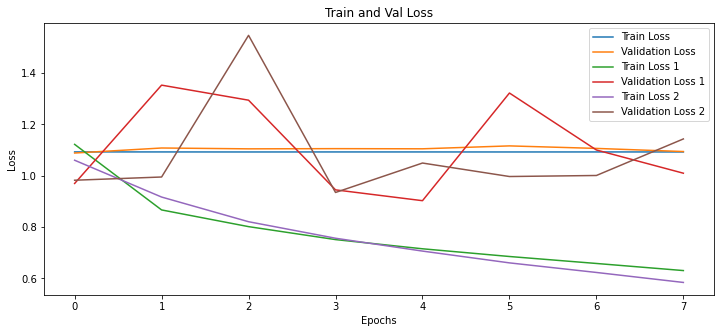

In [35]:
plt.figure(figsize = (12,5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.plot(history2.history['loss'], label='Train Loss 1')
plt.plot(history2.history['val_loss'], label='Validation Loss 1')
plt.plot(history3.history['loss'], label='Train Loss 2')
plt.plot(history3.history['val_loss'], label='Validation Loss 2')
plt.title('Train and Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2. Accuracy plots

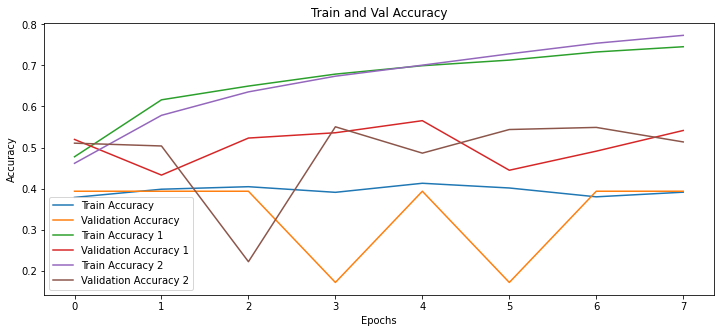

In [36]:
plt.figure(figsize = (12,5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history2.history['accuracy'], label='Train Accuracy 1')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy 1')
plt.plot(history3.history['accuracy'], label='Train Accuracy 2')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy 2')
plt.title('Train and Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

According to the graphs , model2 is performing the best

3. Classification report:

In [37]:
from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = model2.predict(test_padded_sequences)

# Convert the predictions to class labels
test_predictions_class = np.argmax(test_predictions, axis=1)

# Print the classification report
print(classification_report(y_test, test_predictions_class))


16/16 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.91      0.36      0.51       177
           1       0.44      0.86      0.58       139
           2       0.72      0.62      0.66       182

    accuracy                           0.59       498
   macro avg       0.69      0.61      0.59       498
weighted avg       0.71      0.59      0.59       498



**selecting and checking against some random tweets:**

In [38]:
ids = np.random.randint(1,498,10)

In [39]:
ids

array([480, 429, 289, 412, 377,  30, 354, 477, 484,   8])

In [40]:
tweets = []

for i in ids:
  tweets.append(train_df.iloc[i,1])

In [41]:
sent = []

for i in ids:
  if test_predictions_class[i] == 0:
    sent.append('negative')
  elif test_predictions_class[i] == 1:
    sent.append('neutral')
  else:
    sent.append('positive')

In [42]:
df = pd.DataFrame()

df['tweets'] = tweets
df['sentiment'] = sent 

In [43]:
df

,tweets,sentiment
0,"But dont take my word for it , im just a fucke...",neutral
1,Especially since the guy would have been ridic...,neutral
2,"I like that stuff a lot , actually .",positive
3,I think I am going to guilt them boys into giv...,neutral
4,I wish I had thought of that when I saw him .,negative
5,hahahaha i bet you can use it as mascara and e...,positive
6,prince of time and space maybe ...,neutral
7,but my AIM is still up if you want to talk : l...,positive
8,I not sure I just know something is not right .,negative
9,"Not just villains , I had wager .",neutral


The results are satisfactory

Referrence:
https://www.kaggle.com/code/githubsearch/twitter-sentimental-analysis/notebook